# A model for small images

In [2]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
import io
from skimage import io
from pathlib import Path
from PIL import Image

In [3]:
def draw_training_cost(training_cost, validation_cost=None):
    plt.plot(training_cost, label="training cost")
    if validation_cost:
        plt.plot(validation_cost, label="validation cost")
    plt.xlabel("Training iterations")
    plt.ylabel("Log of cost")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        """
        Parameters:
            in_channels: int
                The number of channels in the input image
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        # Taille de sortie : (len_dataloader, 2)
        return x

In [5]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {"building": 0, "leaves": 1}  # Mapping texte → nombre

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.csv.iloc[idx, 0])
        label = self.label_map[self.csv.iloc[idx, 1]]

        image = Image.open(img_name).convert("RGB")  # Ouvre l'image en RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.int64)


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Toutes les images seront en 64x64
    transforms.ToTensor(),  # Convertit en [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalisation [-1,1]
])

population_all = ImageDataset(csv_file="data.csv", root_dir="./", transform=transform)
print(len(population_all))
# Output of population_all[0] is a tuple (image, label)
# Size of the output should be torch.Size([3, 64, 64]) and torch.Size([])
# Where 3 is the number of channels in the image
print(population_all[0][1].shape)
print(population_all[4][1].shape)
print(population_all[9][1].shape)
print(population_all[0][0].shape)
print(population_all[4][0].shape)
print(population_all[9][0].shape)

21
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


In [7]:

size_all = len(population_all)
size_train = int(0.7 * size_all)
size_valid = int(0.1 * size_all)
size_test = size_all - (size_train + size_valid)


(population_train, population_valid, population_test) = torch.utils.data.random_split(population_all, [size_train, size_valid, size_test])

print("Size of the whole set:", len(population_all))
print("Size of the training set:", len(population_train))
print("Size of the validation set:", len(population_valid))
print("Size of the test set:", len(population_test))

Size of the whole set: 21
Size of the training set: 14
Size of the validation set: 2
Size of the test set: 5


In [8]:
cnn = CNN(3)

learning_rate=0.1
linear_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)
crossentropyloss_loss = torch.nn.CrossEntropyLoss()

In [9]:
def train(model, dataset, optimizer, criterion, epochs, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    loss_history = list()

    for i in range(epochs):
        for (x, y) in dataloader:
            #print("x : ",x)
            #print("y : ",y)
            # Forward
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)

            # Log
            loss_history.append(loss.detach())

            #Backward
            loss.backward()
            optimizer.step()

        print("%.2f" % (((i+1)/epochs)*100) + '%' + " of epochs done." , end="\r")
    return loss_history


In [10]:
%%script true # skip this cell when run all, it only show the first training cost without validation

train_log = train(cnn, population_train, linear_optimizer, crossentropyloss_loss, epochs=1000, batch_size=128)

# Plot
draw_training_cost(train_log)

In [11]:
cnn = CNN(3)

learning_rate=0.1
linear_optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)
crossentropyloss_loss = torch.nn.CrossEntropyLoss()

def train_valid(model, dataset,valid, optimizer, criterion, epochs, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=batch_size, shuffle=True)
    
    loss_history = list()
    valid_loss_history = list()

    for i in range(epochs):
        for (x, y) in dataloader:
            #print("x : ",x)
            #print("y : ",y)
            # Forward
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)

            # Log
            loss_history.append(loss.detach())

            #Backward
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            for (x_valid, y_valid) in valid_dataloader:
                valid_loss_history.append(criterion(model(x_valid), y_valid))
        model.train()

        print("%.2f" % (((i+1)/epochs)*100) + '%' + " of epochs done." , end="\r")
    return (loss_history, valid_loss_history)


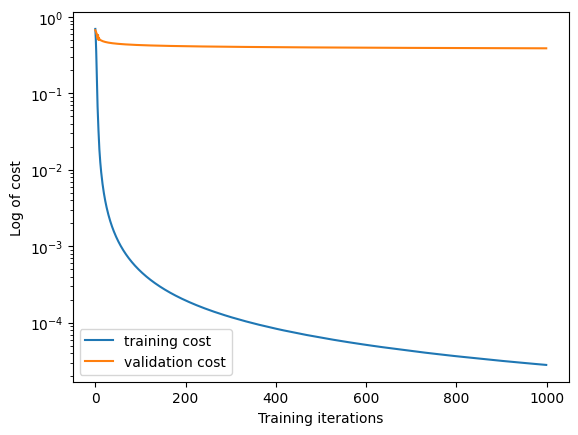

In [12]:
(train_log, valid_log) = train_valid(cnn, population_train,population_valid, linear_optimizer, crossentropyloss_loss, epochs=1000, batch_size=128)

# Plot
draw_training_cost(train_log, valid_log)

In [13]:
# Evalutation du model

cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    # Rappel : Building : 0, Leaves : 1
    for (x, y) in DataLoader(population_test, batch_size=64, shuffle=True):
        print("x.shape : ", x.shape)      # torch.Size([5, 3, 64, 64]) # 5 images, 3 channels, 64x64
        y_pred = cnn(x)     # YPRED est un tableau de 2+len(population_test)
                            # Si YPRED[0] est négatif => C'est un leaves
                            # Si YPRED[1] est négatif => C'est un building
        print("Y_pred data : ",y_pred.data)
        _, predicted = torch.max(y_pred.data, 1)
        print("Initial : ", y)
        print("Predicted : ",predicted)
        
        total += y.size(0)
        correct += (predicted == y).sum().item()
        

    print("Accuracy: ", correct / total)


x.shape :  torch.Size([5, 3, 64, 64])
Y_pred data :  tensor([[  0.8834,  -0.9191],
        [ -3.9800,   3.9794],
        [  9.7719, -10.2878],
        [  9.4424, -10.1171],
        [ -0.8893,   1.0086]])
Initial :  tensor([1, 0, 0, 0, 1])
Predicted :  tensor([0, 1, 0, 0, 1])
Accuracy:  0.6


# Apply the model on a bigger image, possible ?

In [14]:
class FCN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.conv3(x)  # Output will be a spatial map of predictions
        return x
    
    
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):

        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)          
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)           
        x = x.reshape(x.shape[0], -1)  
        x = self.fc1(x)            
        return x